Code to generate a fractal pattern shown to me by a childhood friend (thanks Hoyt). When done by hand, the fractal is drawn on graph paper. It starts with a cross in the middle and then at each iteration any unterminated lines spawn two new lines at 45 degree angles. These new lines extend until the next position on the graph paper (so alternating levels of the pattern have line lengths of 1 and sqrt(2)). If two of the new lines meet, that point is considered closed and new lines will not spawn from it. 

I've added function to start with other patterns than a cross and use different patterns of side lengths, but the results are generally less interesting than the fractal as originally conceived.

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import collections  as mc

plt.rcParams['figure.figsize'] = [20, 20]


In [2]:
def gen_rotation_mat(angle):
    return np.array([[np.cos(angle), np.sin(angle)], 
                     [-np.sin(angle), np.cos(angle)]])

# V1, functional but slow
class NodeOld():
    def __init__(self, position, parent=None, level=0, intersection_counter=None, rotation=np.pi/4):
        self.position = position
        self.parent = parent
        self.level = level
        self.children = []
        if intersection_counter:
            self.intersection_counter = intersection_counter
        else:
            self.intersection_counter = {}
        pos_tuple = tuple(self.position.round(5))
        if pos_tuple in self.intersection_counter:
            self.intersection_counter[pos_tuple] += 1
        else:
            self.intersection_counter[pos_tuple] = 1
        self.active = True
        if type(rotation) is not np.ndarray:
            self.rotation = gen_rotation_mat(rotation)
        else:
            self.rotation = rotation
    
    def _set_active(self):
        pos_tuple = tuple(self.position.round(5))
        self.active = self.intersection_counter[pos_tuple] < 2
        for child in self.children:
            child._set_active()
    
    def draw(self, max_level, color_map=None, scalar_map=None, recursive=True):
        if self.level <= max_level:
            if scalar_map is None:
                if color_map is None:
                    assert 0
                else:
                    cNorm  = colors.Normalize(vmin=0, vmax=max_level)
                    scalar_map = cmx.ScalarMappable(norm=cNorm, cmap=color_map)

            if self.parent:
                xs = [self.parent.position[0], self.position[0]]
                ys = [self.parent.position[1], self.position[1]]
                plt.plot(xs, ys, color=scalar_map.to_rgba(self.level))
            if recursive:
                for child in self.children:
                    child.draw(max_level, scalar_map=scalar_map, recursive=True)
        if not self.level:
            plt.show()

    def spawn(self):
        if self.parent and self.active:
            vec = self.position - self.parent.position
            vec = vec / np.linalg.norm(vec)
            if self.level % 2 == 1:
                vec = vec * np.sqrt(2)
            p1 = self.position + self.rotation.dot(vec)
            p2 = self.position + (self.rotation.T).dot(vec)

            
            self.children = [
                Node(p1, self, self.level + 1, intersection_counter=self.intersection_counter, rotation=self.rotation), 
                Node(p2, self, self.level + 1, intersection_counter=self.intersection_counter, rotation=self.rotation)]
    
    def start_tree(self, scale=1, spacing=4, starting_fronds=None, rotation=None):
        if rotation is None:
            rotation = np.pi / spacing
        if starting_fronds is None:
            starting_fronds = range(spacing)
        v1 = np.array([scale, 0])
        ps = [gen_rotation_mat(2 * np.pi * i / spacing).dot(v1) for i in starting_fronds]
        self.children = [
            Node(p, self, self.level + 1, intersection_counter=self.intersection_counter, rotation=rotation)
            for p in ps]
    
    def _grow(self, max_level):
        if self.level < max_level:
            if not self.children:
                self.spawn()
            for child in self.children:
                child._grow(max_level)
                
    def grow(self, max_level):
        # Need to grow one level at a time to make sure intersection_counter 
        # is properly updated. This isn't efficient, but still works alright.
        assert self.level == 0
        for i in range(1, max_level + 1):
            self._grow(i)
            self._set_active()
            
        

In [3]:
# V2, rewritten to be much faster and more configurable. Uses a set to track
# intersections, removing costly operations incurred from having to update
# intersection_counter in previous code.
class Node():
    def __init__(self, position, parent=None, level=0):
        self.position = position
        self.parent = parent
        self.level = level
        self.children = []

    def pos_tuple(self, precision):
        return tuple(self.position.round(precision))
    
    def check_active(self, occupation_map, precision):
        return not self.pos_tuple(precision) in occupation_map
    
    def spawn(self, rotation, length=1):
        if self.parent:
            vec = self.position - self.parent.position
            vec = vec / np.linalg.norm(vec) * length
            p1 = self.position + rotation.dot(vec)
            p2 = self.position + (rotation.T).dot(vec)

            
            self.children = [
                Node(p1, self, self.level + 1), 
                Node(p2, self, self.level + 1)]
            return self.children

class FractalTree():
    def __init__(self, scale=1, spacing=4, starting_fronds=None, rotation=None, root_position=None, precision=5):
        # Set params
        if rotation is None:
            rotation = np.pi / spacing
        
        self.rotation = gen_rotation_mat(rotation)

        
        # Initialize tree
        if root_position is None:
            self.root = Node(np.array([0, 0]))
        else:
            self.root = Node(root_position)
        level_0 = [self.root]
        
        if starting_fronds is None:
            starting_fronds = range(spacing)
        v1 = np.array([scale, 0])
        ps = [gen_rotation_mat(2 * np.pi * i / spacing).dot(v1) for i in starting_fronds]
        level_1 = [Node(p, self.root, 1) for p in ps]
        
        self.nodes = [level_0, level_1]
        
        # We quantize the node positions to a finite precision to detect 
        # intersections (rounding errors will cause undercount otherwise).
        self.precision = precision
        
        # This is up to date for all nodes not in the outermost level.
        
        # Locations that have one line to them-- these are valid for growth.
        self.occupation_map_1 = set()
        # Locations that have two+ lines to them, these are locked and will not grow.
        self.occupation_map_2 = set()
        for level in self.nodes:
            for node in level:
                self.add_node_occupation(node)
    
    def add_node_occupation(self, node):
        pos_tuple = node.pos_tuple(self.precision)
        if pos_tuple in self.occupation_map_1:
            self.occupation_map_2.add(pos_tuple)
        else:
            self.occupation_map_1.add(pos_tuple)

    def draw(self, color_map='jet'):
        max_level = len(self.nodes)
        cNorm  = colors.Normalize(vmin=0, vmax=max_level)
        scalar_map = cmx.ScalarMappable(norm=cNorm, cmap=color_map)
        lines = []
        cols = []
        for i, level in enumerate(self.nodes[1:]):
            color = scalar_map.to_rgba(i)
            for node in level:
                lines.append([node.parent.position, node.position])
                cols.append(color)
        lc = mc.LineCollection(lines, colors=cols)
        fig, ax = plt.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        plt.show()
        
    def expand(self, length=1):
        new_nodes = []
        for node in self.nodes[-1]:
            if node.check_active(self.occupation_map_2, self.precision):
                new_nodes += node.spawn(self.rotation, length)
        for node in new_nodes:
            self.add_node_occupation(node)
        self.nodes.append(new_nodes)
    
    def grow_to(self, level, lengths=None):
        if lengths is None:
            lengths = [1, np.sqrt(2)]
        # The center node is the 0th level
        while len(self.nodes) <= level:
            length = lengths[(len(self.nodes) - 1) % len(lengths)]
            self.expand(length)

In [4]:
a = time()
tree = FractalTree()
tree.grow_to(10)
b = time()
tree.draw('jet')
c = time()
print("Generation time: %03f" % (b - a))
print("Render time: %03f" % (c - b))

Generation time: 0.007529
Render time: 0.317443


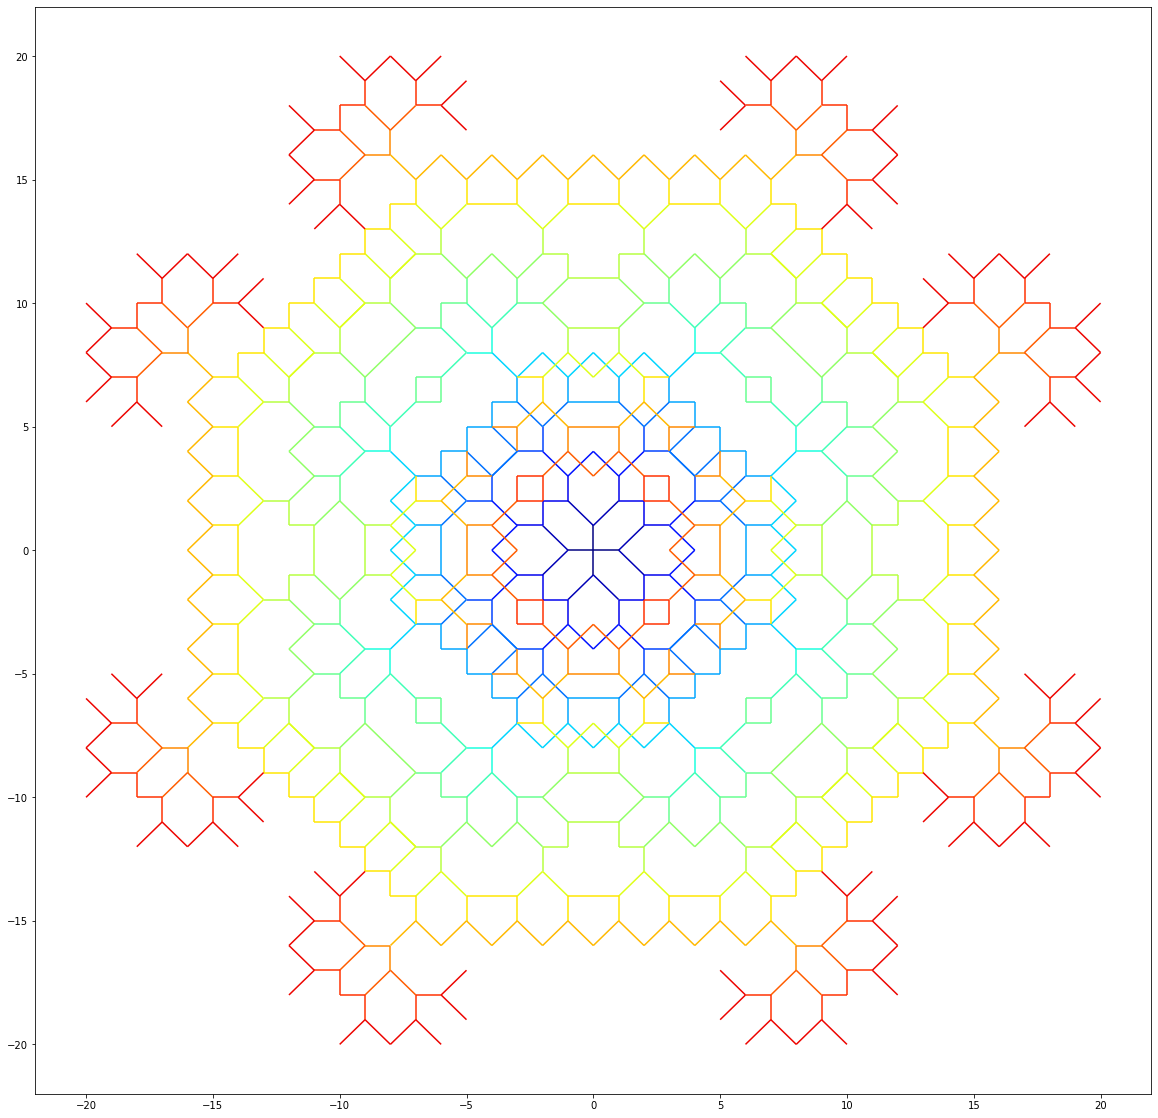

Generation time: 0.040244
Render time: 0.327809


In [5]:
# Branches of the pattern turn inwards as iterations grow
a = time()
tree = FractalTree()
tree.grow_to(20)
b = time()
tree.draw('jet')
c = time()
print("Generation time: %03f" % (b - a))
print("Render time: %03f" % (c - b))

In [6]:
a = time()
tree = FractalTree()
tree.grow_to(100)
b = time()
tree.draw('jet')
c = time()
print("Generation time: %03f" % (b - a))
print("Render time: %03f" % (c - b))

Generation time: 0.688346
Render time: 0.886437


In [7]:
# Fractal has self-similarity at large scales
a = time()
tree = FractalTree()
tree.grow_to(200)
b = time()
tree.draw('jet')
c = time()
print("Generation time: %03f" % (b - a))
print("Render time: %03f" % (c - b))

Generation time: 2.971643
Render time: 2.554321


In [8]:
# Try pattern with other angles and side lengths-- generall produces less interesting results.
tree = FractalTree(spacing=6)
tree.grow_to(7, lengths=[1, 1, 1, 1, 1, 0.5 / np.cos(np.pi / 6), 0.72 / np.cos(np.pi / 6)])
tree.draw()

In [9]:
tree = FractalTree(spacing=5)
tree.grow_to(7, lengths=[1])
tree.draw()

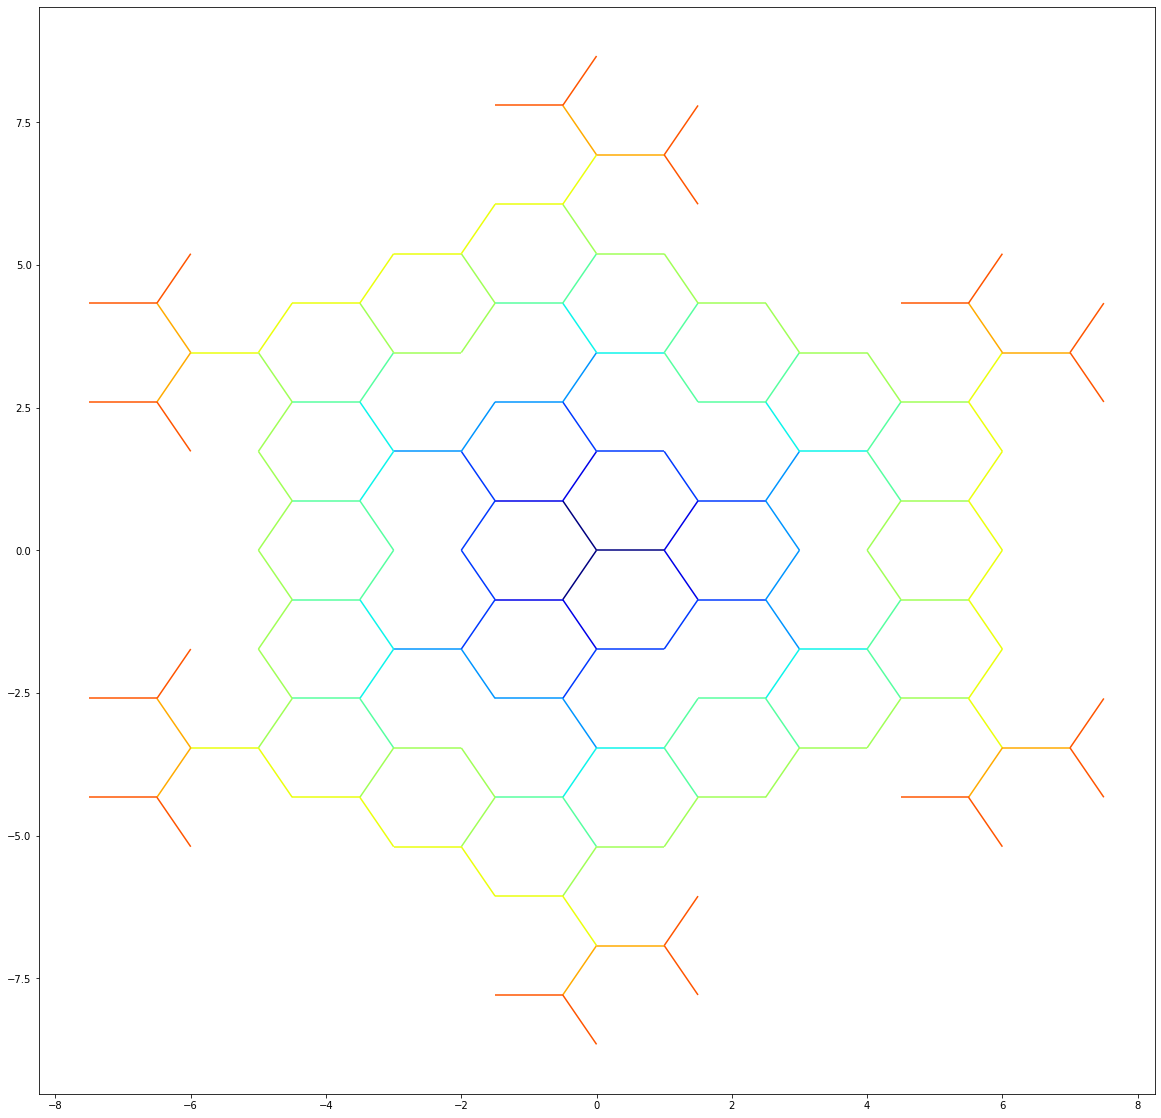

In [10]:
tree = FractalTree(spacing=3)
tree.grow_to(10, lengths=[1])
tree.draw()

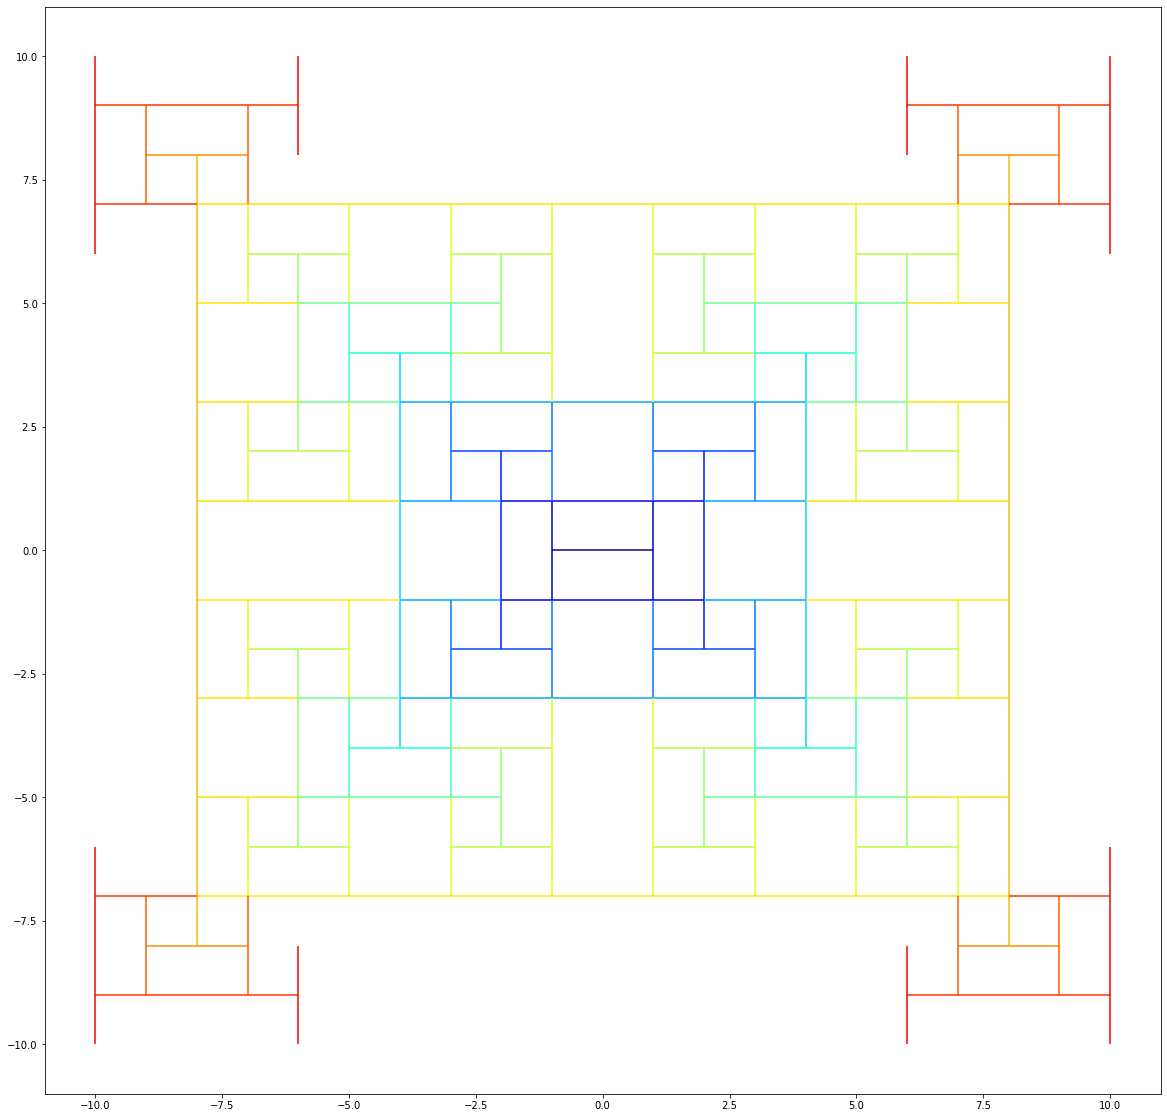

In [11]:
tree = FractalTree(spacing=2)
tree.grow_to(20, lengths=[1])
tree.draw()

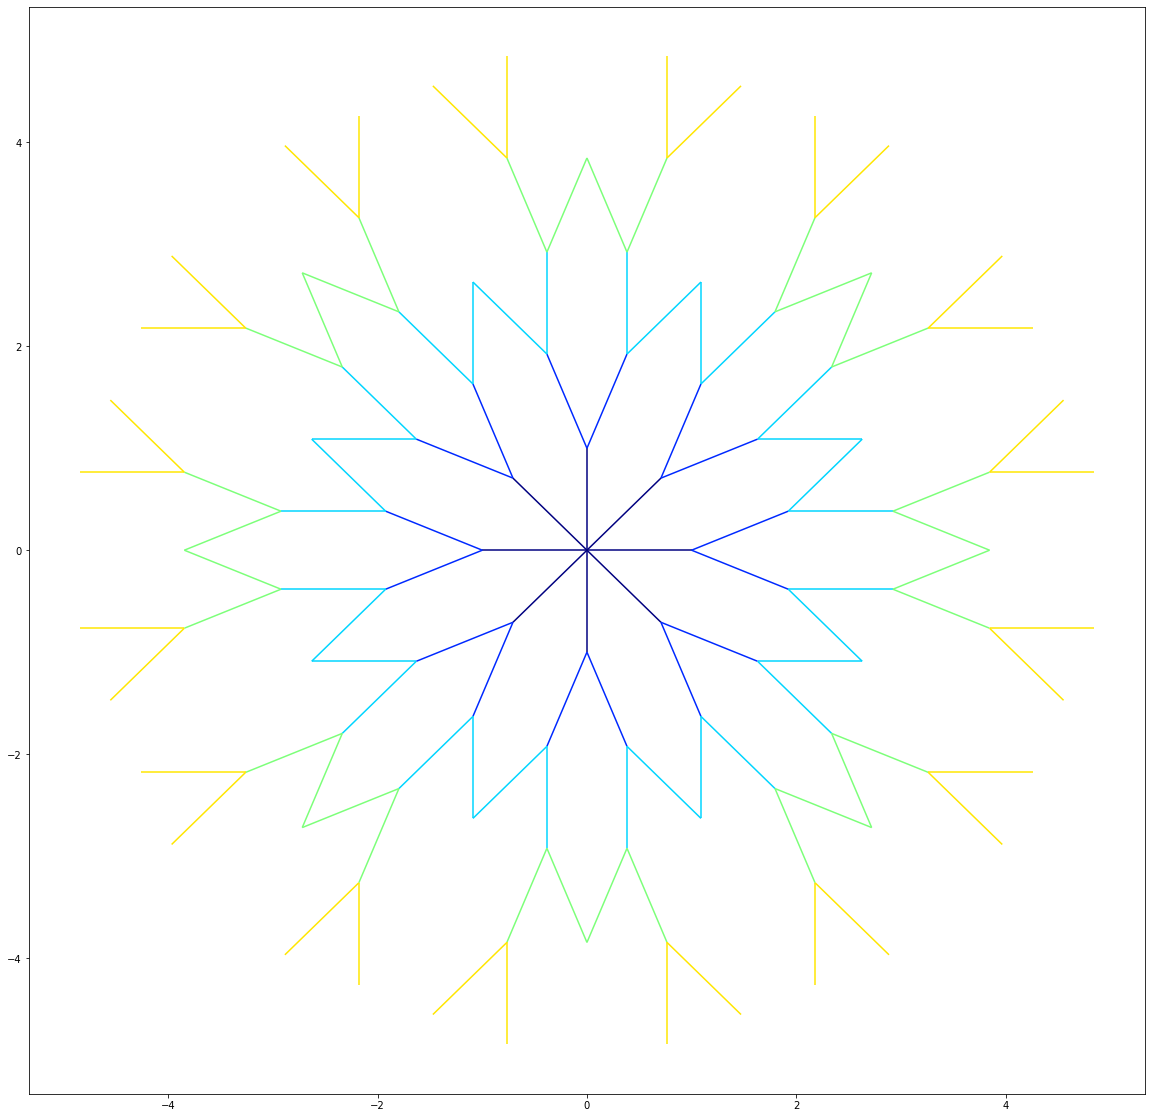

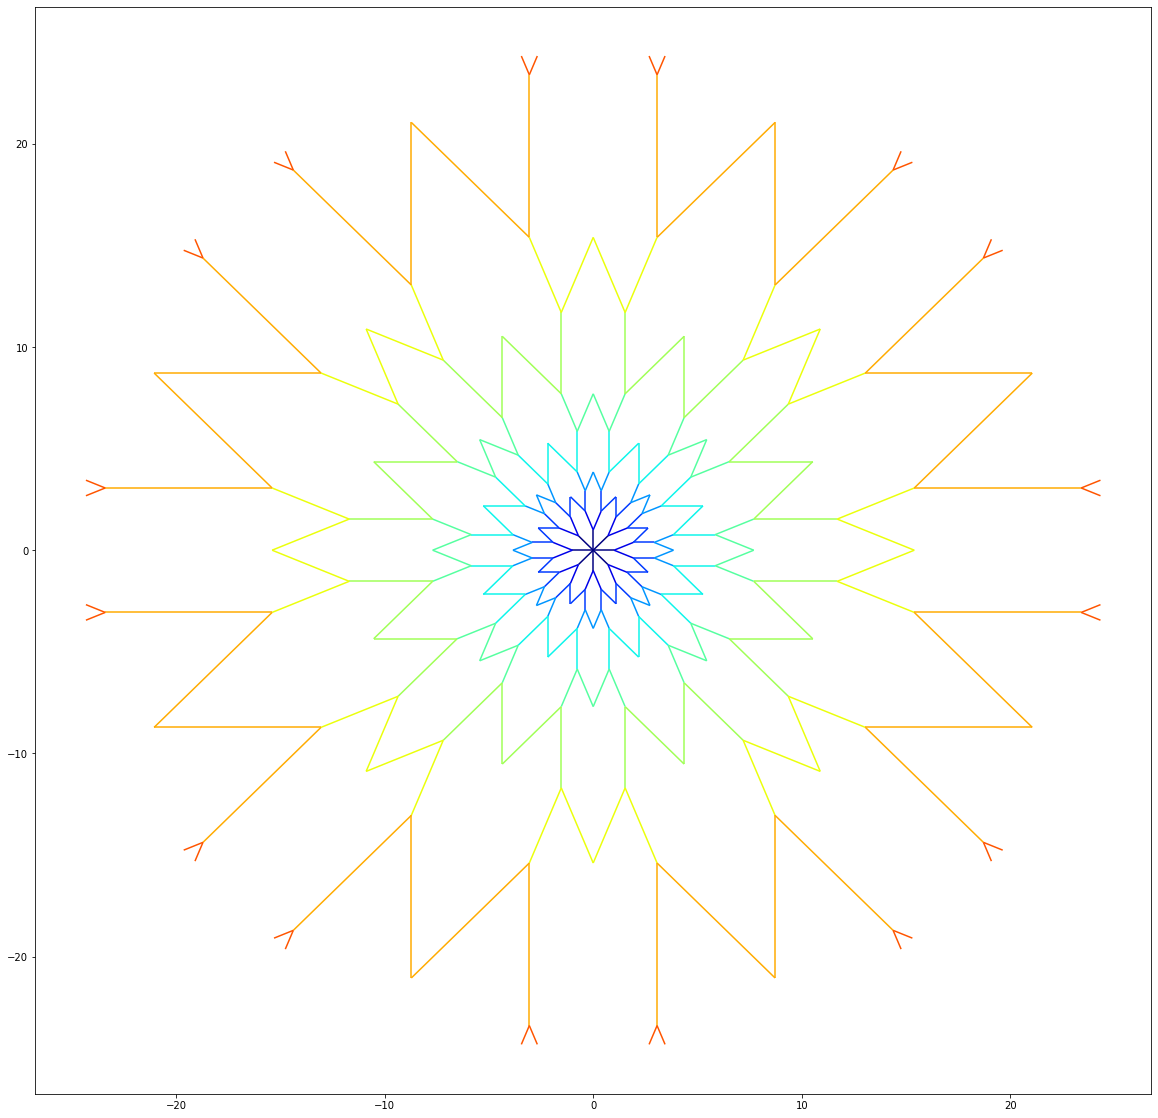

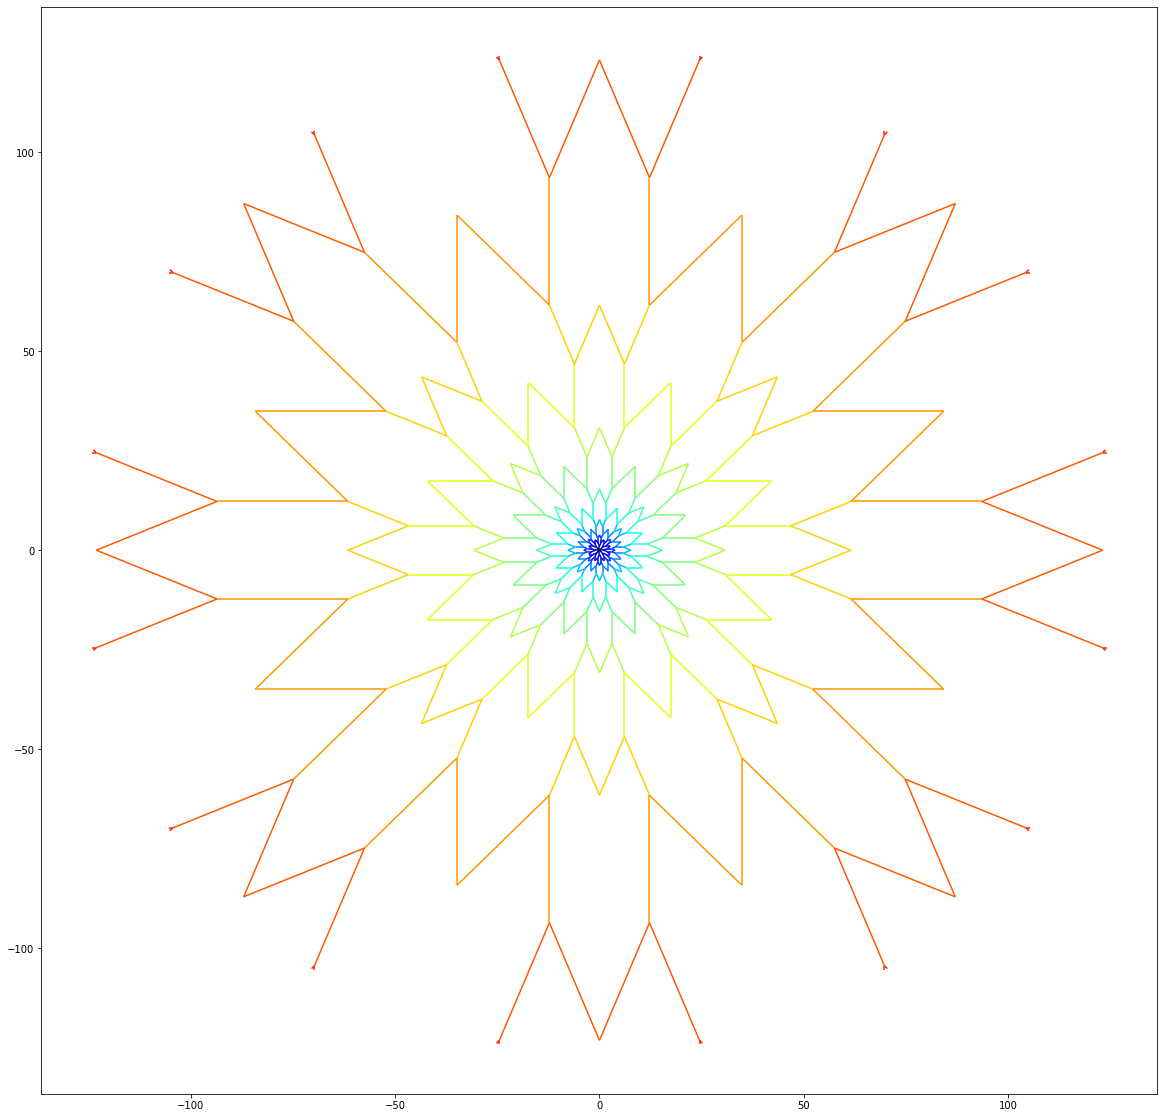

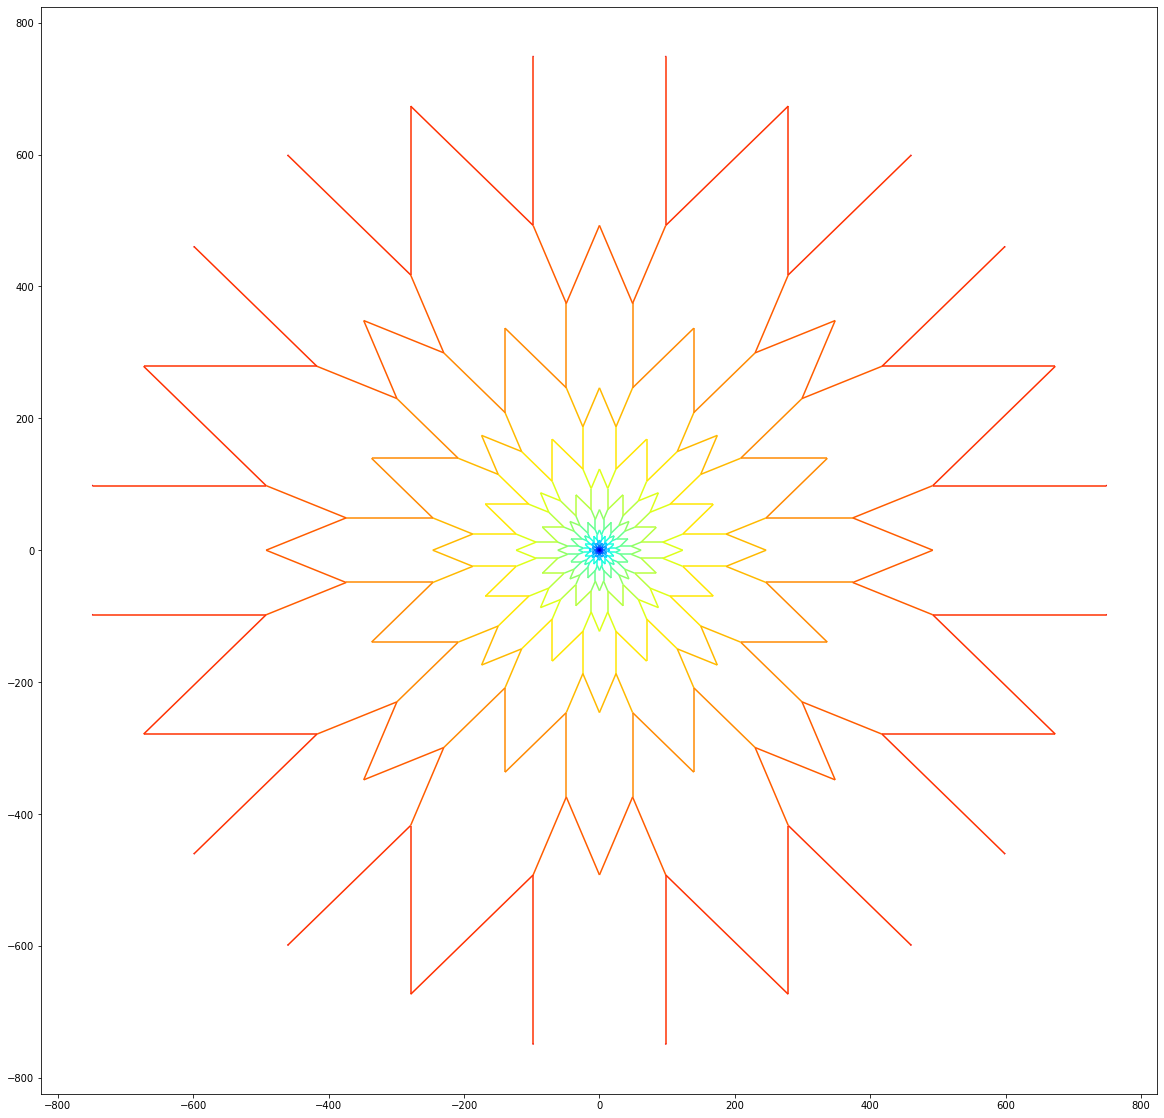

In [12]:
for level in [5, 10, 15, 20]:
    tree = FractalTree(spacing=8)
    lengths = [1, 1, 1, 1]
    # This scheme ensures that the 8-branch fractal will always have clean joining of different branches.
    for i in range(int((level - 4) / 2)):
        lengths += [2 ** (i + 1)] * 2
    lengths = lengths[:level - 1]
    tree.grow_to(level, lengths)
    tree.draw('jet')